# Elaboración de un mapa con etiquetas interactivas - de los Ingresos por Ocupación por Entidad Federativa de la ENOE 1t-2021

Una herramienta adicional frecuente utilizada en los análisis exploratorios cuando tenemos datos geográficos es la elaboración de mapas, en este caso me propusé realizar explorar si existe algún comportamiento regional. 

## Elaboración del mapa 

In [1]:
#Importamos las librerias necesarias 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import adjustText as aT

In [2]:
#cargamos el dataframe
df = pd.read_csv('geo_enoe.csv')

In [3]:
#convertimos el csv en dataframe
from shapely import wkt

df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='epsg:4326')#crs significa Coordinate Reference System Format

In [4]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

In [5]:
gdf.head()

,CODIGO,ESTADO,geometry,eda,n_hij,hrsocup,ingocup,ing_x_hrs,anios_esc,inegi_id,ent,ingocup_empleo formal,ingocup_empleo informal,ingocup_hombre,ingocup_mujer,ing_m_vs_h,ing_inf_vs_for
0,MX02,Baja California,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405...",37.461371,1.953057,44.476211,7728.147534,41.578779,10.197294,2.0,BC,8377.291888,6487.597205,8279.855273,6899.983624,0.833346,0.774427
1,MX03,Baja California Sur,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302...",37.661267,1.772887,42.726804,7148.584683,41.521757,10.716495,3.0,BCS,7977.641439,5938.041667,7811.716456,6226.271127,0.797043,0.744335
2,MX18,Nayarit,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475...",37.313514,1.881333,41.813213,6157.559159,36.298375,10.900300,18.0,Nayarit,7173.721374,5248.908987,6742.174863,5444.328000,0.807503,0.731686
3,MX14,Jalisco,"POLYGON ((-101.52490 21.85664, -101.58830 21.7...",35.790096,1.734095,42.872204,6862.089776,38.838339,10.138658,14.0,Jalisco,7851.851803,5921.661682,7347.071429,6108.904568,0.831475,0.754174
4,MX01,Aguascalientes,"POLYGON ((-101.84620 22.01176, -101.96530 21.8...",36.094589,1.885428,45.753302,6318.214742,33.398984,9.931828,1.0,Aguascalientes,7104.476946,5302.370117,6826.098066,5500.177976,0.805757,0.746342


In [12]:
fig = px.choropleth_mapbox(
    gdf,
    locations=gdf.index,
    geojson=gdf.geometry,
    color="ingocup",
    color_continuous_scale= 'Bluered_r',
    hover_name="ent",
    hover_data=["ingocup"],
    title="Ingresos mensuales por ocupación",
    mapbox_style="carto-positron",
    center={"lat": 22.451054, "lon": -99.125519},
    zoom=3.2,
    opacity=0.5,
)
fig.show()

### Observaciones 

1. Los estados representados con colores más cercanos al rojo, es decir los que muestran los menores ingresos se ubican principalmente en la zona sur del país, mientras que los que tienen mayores ingresos promedio por ocupación se ubican principalmente en el norte del país.

## The spatial lag

The spatial lag o rezago espacial, es el producto espacial de los pesos en la matrix W dados por la variable Y. 

In [64]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [65]:
df = pd.read_csv('geo_enoe.csv')

In [71]:
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

In [72]:
y = df['ingocup']
ylag = lps.weights.lag_spatial(wq, y)

In [73]:
ylag

array([6877.73681682, 7728.14753383, 6181.03399491, 6070.46808102,
       6109.30366867, 6256.13892805, 5888.67644132, 5638.1214146 ,
       6189.73988079, 5513.40649508, 5414.28498774, 6339.31626627,
       5352.88754192, 6036.12011489, 5696.92583195, 5190.24305244,
       5489.92713703, 5322.26381302, 5247.74223297, 5159.85569228,
       5346.95969382, 5124.82619981, 7157.28813031, 6498.10675866,
       6341.22669772, 6325.92457427, 6427.56060386, 6498.67528117,
       6368.9554645 , 6271.70986032, 6414.92003538, 5458.36172607])

In [80]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

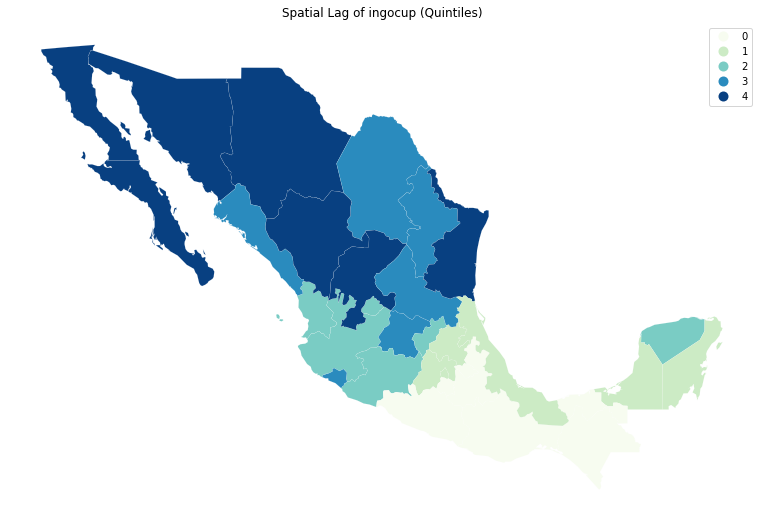

In [81]:
f, ax = plt.subplots(1, figsize=(16, 9))
df.assign(cyl=ylagq5.yb).plot(column='cyl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag of ingocup (Quintiles)")

plt.show()

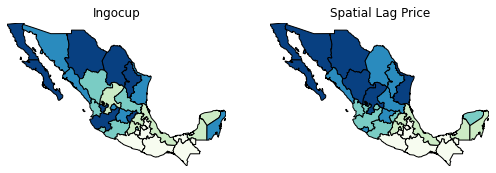

In [82]:
df['lag_ingocup'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='ingocup', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Ingocup")
df.plot(column='lag_ingocup', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### Global spatial autocorrelation

### Mapa binario

In [84]:
y.median()

5987.050957671452

In [85]:
yb = y > y.median()
sum(yb)

16

In [87]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
df['yb'] = yb

<AxesSubplot:>

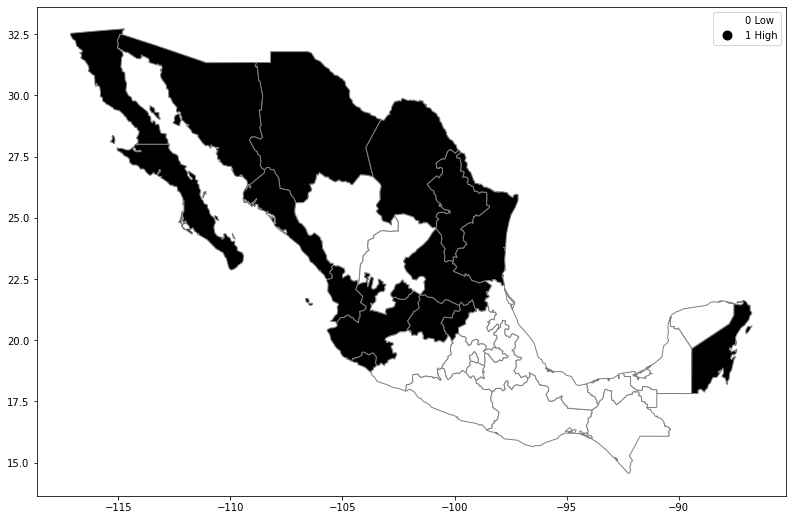

In [92]:
fig, ax = plt.subplots(figsize=(16,9), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

Encontramos que salvo el caso de Quintana Roo, el valor promedio de los ingresos por ocupación es superior en elos estados ubicados en las regiones del norte, bajío y centro occidente. Así mismo los estados que tienen menores ingresos por ocupación se ubican en las regiones centro y sur, a excepción de los estados de Durango y Zacatecas. 

In [93]:
wq.transform = 'r'

In [95]:
y = df['ingocup']

In [96]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.5552957783106874

Text(0.5, 0, "Moran's I")

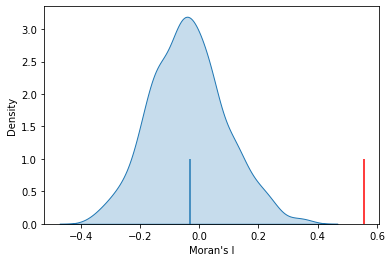

In [97]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")


In [98]:
mi.p_sim

0.001

Local autocorrelation

In [99]:
np.random.seed(12345)
import esda

In [100]:
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, df['ingocup'])

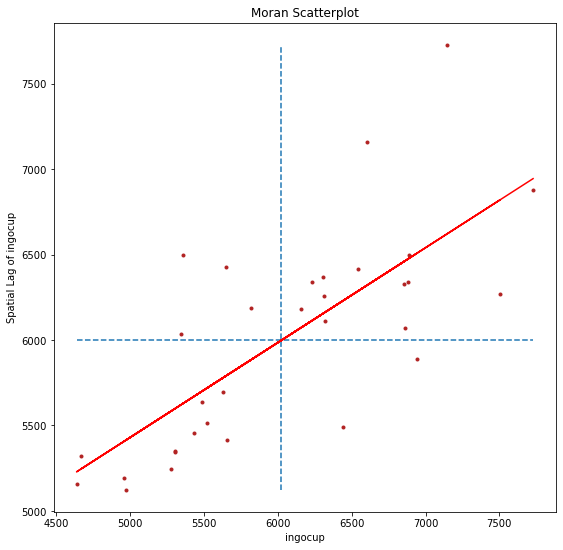

In [104]:
ingocup = df['ingocup']
b, a = np.polyfit(ingocup, lag_ingocup, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(ingocup, lag_ingocup, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(ingocup.mean(), lag_ingocup.min(), lag_ingocup.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lag_ingocup.mean(), ingocup.min(), ingocup.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(ingocup, a + b*ingocup, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of ingocup')
plt.xlabel('ingocup')
plt.show()


In [105]:
li = esda.moran.Moran_Local(y, wq)

In [106]:
li.q

array([1, 1, 1, 1, 1, 1, 4, 3, 2, 3, 3, 1, 3, 2, 3, 3, 4, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 3])

In [107]:
(li.p_sim < 0.05).sum()

11

In [108]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [109]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

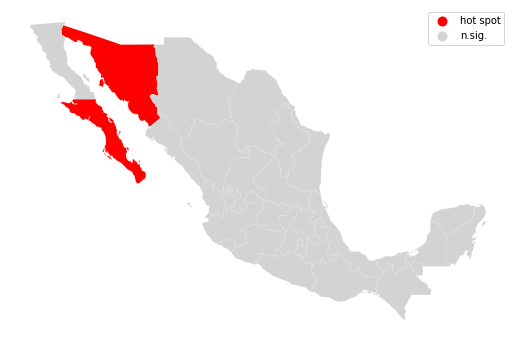

In [110]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [111]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

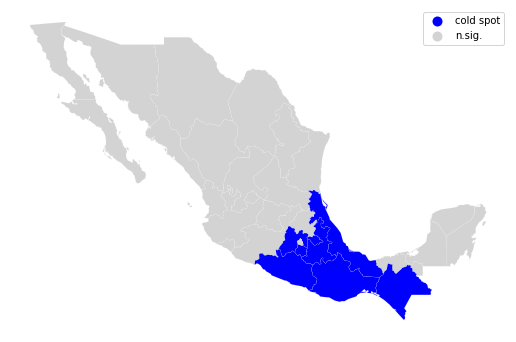

In [112]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [113]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

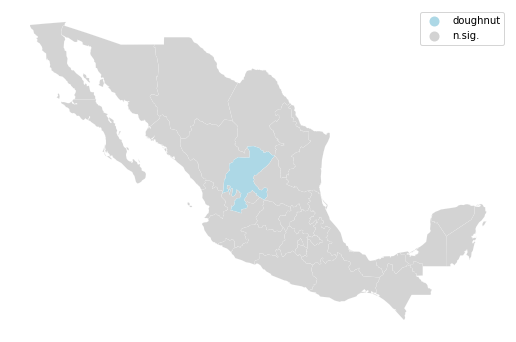

In [114]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [115]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

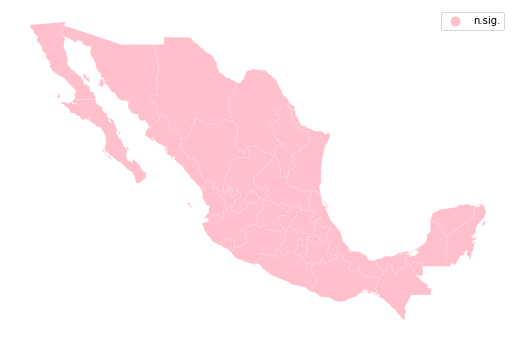

In [116]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [117]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 0, 3,
       1, 0, 0, 0, 0, 2, 0, 0, 0, 3])

In [122]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

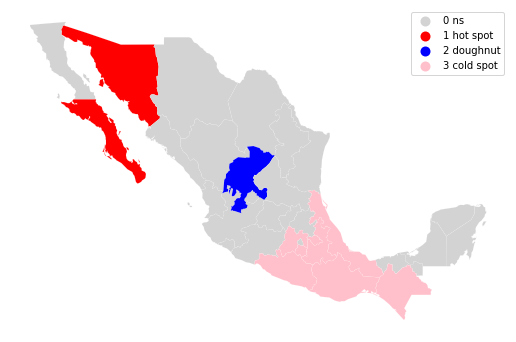

In [123]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()